# PL612-Baldy analysis of initial land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Baldy station.

In [1]:
%pylab inline
import csv
with open('BALDY xyz-ETRF2000.txt', 'r') as csv_file:
    csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                for row in csv.reader(csv_file, delimiter=',')
                if 'ETRS' not in row[1]]
print len(csv_rows)
csv_rows[0:3]

Populating the interactive namespace from numpy and matplotlib
190


[('P001', array([ 3551472.68442,  1334258.18577,  5110148.55494])),
 ('P002', array([ 3551472.07298,  1334240.66937,  5110154.26542])),
 ('P003', array([ 3551473.86773,  1334220.6999 ,  5110159.5722 ]))]

It seems like we succeeded in reading the file. The variable *position_dict* can be used to look up positions based on the name of the point. *all_positions* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

In [2]:
position_dict = dict(csv_rows)
all_positions = array([row[1] for row in csv_rows])
all_names = [row[0] for row in csv_rows]
mean_position = all_positions.mean(axis=0)
print 'Mean position (ETRS89): ', mean_position

Mean position (ETRS89):  [ 3551510.08303279  1334141.24830537  5110155.56365142]


And in geographic coordinates in radians and meters:

In [3]:
from lofargeo import *
geo_mean = geographic_from_xyz(mean_position)
print '''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean

lat_rad : 0.9353819916 rad
lon_rad : 0.3593444793 rad
height_m: 172.726 m


The normal vector to the WGS84 ellipsoid is then

In [4]:
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
repr(ellipsoid_normal)

'array([ 0.55560203,  0.20871448,  0.80482585])'

## Slope of the field and selection of subset of points

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [5]:
local_north_projection = projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = transform(all_positions, mean_position, local_north_projection.T)

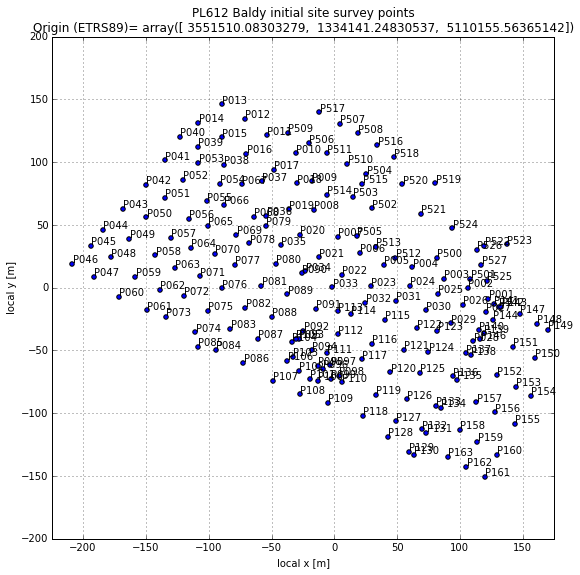

In [6]:
figure(figsize=(9,9))
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1
         , name)
axis('equal')
grid()


title('PL612 Baldy initial site survey points\nOrigin (ETRS89)= %r' %
      mean_position)
xlabel('local x [m]')
ylabel('local y [m]')

The following function interpolates between unstructured points in 3D space.

In [7]:
xyz_interpol_fn = interpolation_function(local_north_xyz)
x_m, y_m = meshgrid(arange(-220, 180), arange(-160, 160))
z_m = xyz_interpol_fn(x_m, y_m)

Now let's plot a map of elevation of the selection relative to the mean position of all points.

/usr/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


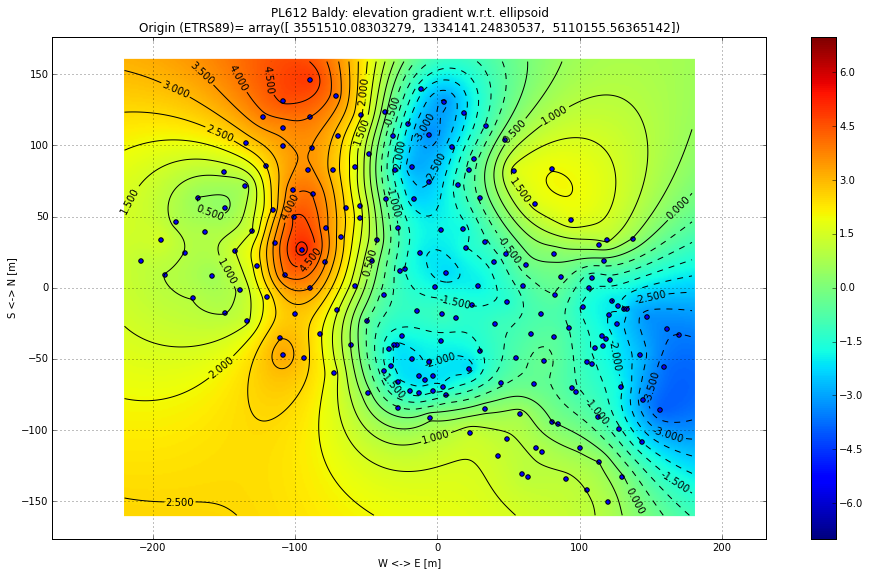

In [8]:
figure(figsize=(16,9))
imshow(z_m, origin='lower', vmin=-7, vmax=7.0, extent=(-220.5, 180.5, -160.5, 160.5))
colorbar()
cnt = contour(x_m, y_m, z_m, levels=arange(-10.0, +10.0, 0.50), colors='black')
cnt.clabel(inline=True)
xlabel('W <-> E [m]')
ylabel('S <-> N [m]')
axis('equal')
grid()
title('PL612 Baldy: elevation gradient w.r.t. ellipsoid\nOrigin (ETRS89)= %r' %
      mean_position)
scatter(local_north_xyz[:,0], local_north_xyz[:,1])


## Best fit plane and deviations from that plane

Because I do not yet have a map of the Baldy station, I have used all points that might hold the LBA and HBA stations to fit a plane through. As soon as I have a drawing of the area, and ETRS89 coordinates of at least 4 points that are marked clearly on that drawing, I can make a better fit.

The red points below (the ones in the *selection_xyz* and *selection_etrs* variables) are used to fit the best fit plane to the station.  They are selected, because it looks like an LBA station would best fit somewhere near the origin in the above map, and an HBA field somewhat to the east of the LBA field, near (80, 0) or thereabouts. Assuming that that is the case, I can make a smaller selection of points, and fit a plane to that area.

In [9]:
min_x, max_x = -50, 150
min_y, max_y = -75, 50
selection_xyz = array([xyz for xyz in local_north_xyz
                      if xyz[0] > min_x and xyz[0] < max_x 
                      and xyz[1]> min_y and xyz[1] < max_y])
selection_etrs = array([etrs for etrs, xyz in zip(all_positions, local_north_xyz)
                      if xyz[0] > min_x and xyz[0] < max_x
                      and xyz[1]> min_y and xyz[1] < max_y])
print ('The selection contains %d points.' % len(selection_etrs))

The selection contains 82 points.


In [10]:
solution = fit_plane(selection_etrs)
rotation_matrix = projection_matrix(LOFAR_XYZ0_m, solution['normal'])
print 'Normal vector: ', repr(solution['normal'])
print 'Mean position: ', repr(solution['mean'])
print 'Rotation matrix:\n', repr(rotation_matrix)

Normal vector:  array([ 0.56297138,  0.21120525,  0.79903415])
Mean position:  array([ 3551508.97752354,  1334189.74106061,  5110142.18217792])
Rotation matrix:
array([[-0.20181181, -0.80145818,  0.56297138],
       [ 0.97266016, -0.09656374,  0.21120525],
       [-0.11490955,  0.59020355,  0.79903415]])


In [11]:
station_pqr = transform(all_positions, solution['mean'], rotation_matrix.T)
selection_pqr = transform(selection_etrs, solution['mean'], rotation_matrix.T)
station_height_deviation_fn = interpolation_function(station_pqr)
print 'p range: ', station_pqr[:,0].min(),'--', station_pqr[:,0].max()
print 'q range: ', station_pqr[:,1].min(),'--', station_pqr[:,1].max()

p range:  -257.254948738 -- 124.529045871
q range:  -113.065914346 -- 146.386684037


In [12]:
p_m, q_m = meshgrid(arange(-270, 130), arange(-120, 150))
r_m = station_height_deviation_fn(p_m, q_m)

[ -4.50000000e+01   5.00000000e+00  -1.24431132e-10]
[  3.50000000e+01   1.15000000e+01  -3.13615800e-11]
[  8.00000000e+01   6.50000000e+00   9.30695521e-11]


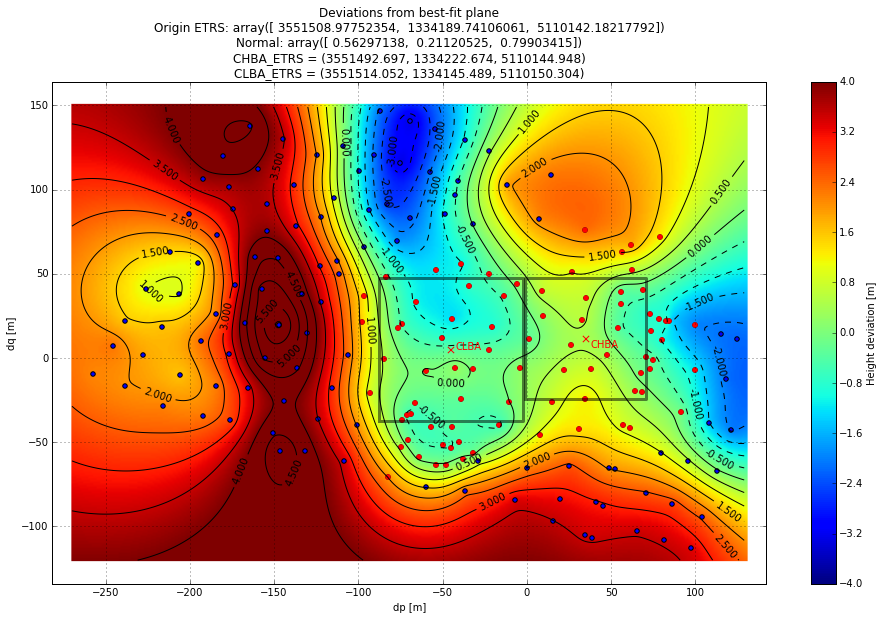

In [18]:
figure(figsize=(16, 9))
imshow(r_m, origin='lower', extent=(-270.5, 130.5, -120.5, 150.5), vmin=-4, vmax=+4)
axis('equal')
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black')
cnt.clabel(inline=True)
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (solution['mean'], solution['normal']))
xlabel('dp [m]')
ylabel('dq [m]')
scatter(station_pqr[:,0], station_pqr[:,1])
scatter(selection_pqr[:,0], selection_pqr[:,1], color='red')

lba_box_width_m = 85.0
hba_box_width_m = 72

clba_pqr = array([-45, +5, 0.0])
plot([clba_pqr[0] - lba_box_width_m/2.0,
      clba_pqr[0] + lba_box_width_m/2.0,
      clba_pqr[0] + lba_box_width_m/2.0,
      clba_pqr[0] - lba_box_width_m/2.0,
      clba_pqr[0] - lba_box_width_m/2.0], 
     [clba_pqr[1] - lba_box_width_m/2.0,
      clba_pqr[1] - lba_box_width_m/2.0,
      clba_pqr[1] + lba_box_width_m/2.0,
      clba_pqr[1] + lba_box_width_m/2.0,
      clba_pqr[1] - lba_box_width_m/2.0],
     color='black', alpha=0.5, lw=3)

chba_pqr = array([+35, 11.5, 0.0])
plot([chba_pqr[0] - hba_box_width_m/2.0,
      chba_pqr[0] + hba_box_width_m/2.0,
      chba_pqr[0] + hba_box_width_m/2.0,
      chba_pqr[0] - hba_box_width_m/2.0,
      chba_pqr[0] - hba_box_width_m/2.0], 
     [chba_pqr[1] - hba_box_width_m/2.0,
      chba_pqr[1] - hba_box_width_m/2.0,
      chba_pqr[1] + hba_box_width_m/2.0,
      chba_pqr[1] + hba_box_width_m/2.0,
      chba_pqr[1] - hba_box_width_m/2.0],
     color='black', alpha=0.5, lw=3)

CHBA_ETRS = solution['mean']+(transform([chba_pqr], zeros(3), rotation_matrix)[0,:])
CLBA_ETRS = solution['mean']+(transform([clba_pqr], zeros(3), rotation_matrix)[0,:])
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r
CHBA_ETRS = (%.3f, %.3f, %.3f)
CLBA_ETRS = (%.3f, %.3f, %.3f)''' %
      (solution['mean'], solution['normal'],
       CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2],
       CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
chba_pqr = transform([CHBA_ETRS], solution['mean'], rotation_matrix.T)[0]
scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='red')
clba_pqr = transform([CLBA_ETRS], solution['mean'], rotation_matrix.T)[0]
scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='red')

print clba_pqr
print chba_pqr
print chba_pqr - clba_pqr


It seems that with the estimates for the LBA and HBA centres, assuming that we have free placement anywhere within the surveyed area, the LBA and HBA stations can both be built with their normal spacings, requiring a layer of at most about 1m thick to be moved around to crape off the bumps and fill the holes. Please let me know if I am mistaken here.

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. It is the second column of the rotation matrix. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, I determine the deviation between the reference direction (the "q" axis) and geographic north in the ETRS89 reference system.

In [14]:
ref_dir = rotation_matrix[:,1] 
print 'Reference direction (q direction in ETRS89): ', ref_dir

Reference direction (q direction in ETRS89):  [-0.80145818 -0.09656374  0.59020355]


To determine the angle between the reference direction of the station and ETRS89 north, we need to project the reference direction onto the tangent plane to the ellipsoid at the mean position of the field, and compute the normalized inner product between the "reference direction" of the local north frame and the projected reference direction.

In [15]:
tip_refdir = solution['mean']+ref_dir
projected_tip_ref_dir = transform(array([tip_refdir]), solution['mean'],
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

In [16]:
print ('First estimate of reference direction for PL612 Baldy is\
 %.4f degrees east from north.' %
       (deviation*180/pi,))

First estimate of reference direction for PL612 Baldy is 11.0377 degrees east from north.
